# Sentiment Analysis Project
A comprehensive implementation of various models for sentiment analysis

## Phase 1: Data Preparation (Jan 25-31)


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# Load the labeled dataset
labeled_data = pd.read_csv('/Users/ishitagupta/Library/CloudStorage/GoogleDrive-2023mt12060@wilp.bits-pilani.ac.in/My Drive/SSZG628T - Dissertation/Code Execution/Dataset/Sentiment Analysis labelled/amazon_reviews.csv')
print(f"Dataset shape: {labeled_data.shape}")
print(labeled_data.head())

Dataset shape: (400000, 2)
                                              Review  Label
0  Great CD: My lovely Pat has one of the GREAT v...      1
1  One of the best game music soundtracks - for a...      1
2  Batteries died within a year ...: I bought thi...      0
3  works fine, but Maha Energy is better: Check o...      1
4  Great for the non-audiophile: Reviewed quite a...      1


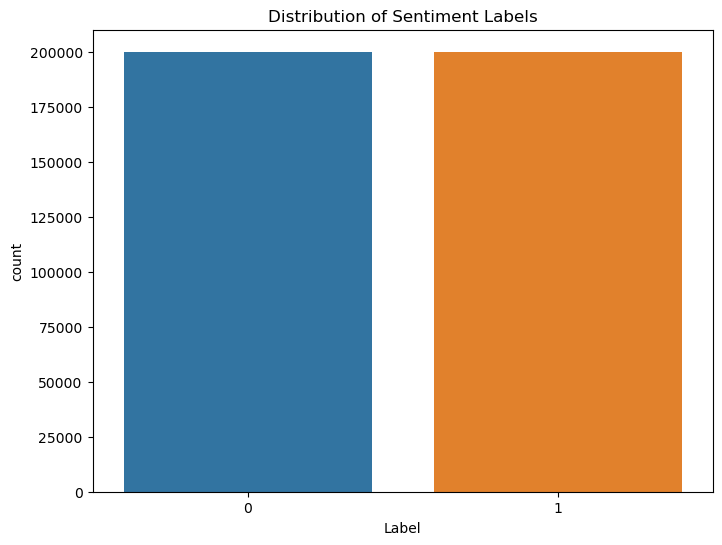

In [5]:
# Exploratory Data Analysis
plt.figure(figsize=(8, 6))
sns.countplot(x='Label', data=labeled_data)
plt.title('Distribution of Sentiment Labels')
plt.show()

In [6]:
# Text preprocessing
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()

    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)

    # Tokenize
    tokens = text.split()

    # Remove stopwords and lemmatize
    stop_words = set(stopwords.words('english'))
    lemmatizer = WordNetLemmatizer()
    cleaned_tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]

    return ' '.join(cleaned_tokens)

# Apply preprocessing
labeled_data['processed_text'] = labeled_data['Review'].apply(preprocess_text)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/ishitagupta/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [7]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    labeled_data['processed_text'],
    labeled_data['Label'],
    test_size=0.2,
    random_state=42
)

print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Training set size: 320000
Test set size: 80000


## Phase 2: Classical ML Models

In [8]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
import time

In [9]:
# Function to evaluate model performance
def evaluate_model(model, X_test, y_test, model_name):
    start_time = time.time()
    y_pred = model.predict(X_test)
    end_time = time.time()

    # Performance metrics
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    inference_time = end_time - start_time

    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'inference_time': inference_time,
        'report': report,
        'conf_matrix': conf_matrix
    }

In [10]:
# Create TF-IDF vectorizer
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [11]:
# 1. Logistic Regression
lr_model = LogisticRegression(max_iter=1000, random_state=42)
lr_model.fit(X_train_tfidf, y_train)
lr_results = evaluate_model(lr_model, X_test_tfidf, y_test, "Logistic Regression")



===== Logistic Regression =====
Accuracy: 0.8860
Inference time: 0.0036 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     39896
           1       0.88      0.89      0.89     40104

    accuracy                           0.89     80000
   macro avg       0.89      0.89      0.89     80000
weighted avg       0.89      0.89      0.89     80000

Confusion Matrix:
[[35140  4756]
 [ 4364 35740]]


In [12]:
# 3. Naive Bayes
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)
nb_results = evaluate_model(nb_model, X_test_tfidf, y_test, "Naive Bayes")

# Store results for comparative analysis
#classical_results = [lr_results, svm_results, nb_results]
classical_results = [lr_results, nb_results]


===== Naive Bayes =====
Accuracy: 0.8402
Inference time: 0.0118 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84     39896
           1       0.84      0.84      0.84     40104

    accuracy                           0.84     80000
   macro avg       0.84      0.84      0.84     80000
weighted avg       0.84      0.84      0.84     80000

Confusion Matrix:
[[33507  6389]
 [ 6393 33711]]


## Phase 3: Deep Learning Models

In [13]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Bidirectional, GRU, Dense, Dropout

In [14]:
# Tokenize and pad sequences
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len)
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len)

In [15]:
# 1. LSTM Model
lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    LSTM(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
lstm_model.summary()

/Users/ishitagupta/anaconda3/lib/python3.11/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [16]:
# Training with early stopping to prevent overfitting
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

In [17]:
# Train the LSTM model (limit epochs for Colab/Kaggle constraints)
lstm_history = lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,  # Limited epochs due to Colab constraints
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 537s 119ms/step - accuracy: 0.8478 - loss: 0.3498 - val_accuracy: 0.8967 - val_loss: 0.2496
Epoch 2/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 489s 109ms/step - accuracy: 0.9050 - loss: 0.2364 - val_accuracy: 0.9018 - val_loss: 0.2406
Epoch 3/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 473s 105ms/step - accuracy: 0.9160 - loss: 0.2099 - val_accuracy: 0.9020 - val_loss: 0.2399
Epoch 4/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 489s 109ms/step - accuracy: 0.9268 - loss: 0.1848 - val_accuracy: 0.8988 - val_loss: 0.2493
Epoch 5/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 469s 104ms/step - accuracy: 0.9352 - loss: 0.1641 - val_accuracy: 0.8987 - val_loss: 0.2619


In [18]:
# 2. Bidirectional LSTM
bi_lstm_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2)),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

bi_lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
bi_lstm_model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [19]:
# Train the Bi-LSTM model
bi_lstm_history = bi_lstm_model.fit(
    X_train_pad, y_train,
    epochs=5,  # Limited epochs due to Colab constraints
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 658s 146ms/step - accuracy: 0.8460 - loss: 0.3498 - val_accuracy: 0.8955 - val_loss: 0.2506
Epoch 2/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 1185s 263ms/step - accuracy: 0.9046 - loss: 0.2385 - val_accuracy: 0.9012 - val_loss: 0.2424
Epoch 3/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 655s 146ms/step - accuracy: 0.9163 - loss: 0.2109 - val_accuracy: 0.9013 - val_loss: 0.2399


In [20]:
# 3. GRU Model
gru_model = Sequential([
    Embedding(max_words, 128, input_length=max_len),
    GRU(64, dropout=0.2, recurrent_dropout=0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

gru_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
gru_model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [21]:
# Train the GRU model
gru_history = gru_model.fit(
    X_train_pad, y_train,
    epochs=5,  # Limited epochs due to Colab constraints
    batch_size=64,
    validation_split=0.1,
    callbacks=[early_stopping]
)

Epoch 1/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 493s 109ms/step - accuracy: 0.7676 - loss: 12852.0869 - val_accuracy: 0.7745 - val_loss: 0.4698
Epoch 2/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 474s 105ms/step - accuracy: 0.8297 - loss: 0.3823 - val_accuracy: 0.7827 - val_loss: 0.4634
Epoch 3/5
4500/4500 ━━━━━━━━━━━━━━━━━━━━ 486s 108ms/step - accuracy: 0.8440 - loss: 0.3895 - val_accuracy: 0.7821 - val_loss: 0.4643


In [22]:
# Evaluate deep learning models
def evaluate_dl_model(model, X_test, y_test, model_name):
    start_time = time.time()
    loss, accuracy = model.evaluate(X_test, y_test)
    end_time = time.time()

    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    report = classification_report(y_test, y_pred)
    conf_matrix = confusion_matrix(y_test, y_pred)
    inference_time = end_time - start_time

    print(f"\n===== {model_name} =====")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Loss: {loss:.4f}")
    print(f"Inference time: {inference_time:.4f} seconds")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'model_name': model_name,
        'accuracy': accuracy,
        'loss': loss,
        'inference_time': inference_time,
        'report': report,
        'conf_matrix': conf_matrix
    }

In [23]:
lstm_results = evaluate_dl_model(lstm_model, X_test_pad, y_test, "LSTM")
bi_lstm_results = evaluate_dl_model(bi_lstm_model, X_test_pad, y_test, "Bidirectional LSTM")
gru_results = evaluate_dl_model(gru_model, X_test_pad, y_test, "GRU")

dl_results = [lstm_results, bi_lstm_results, gru_results]

2500/2500 ━━━━━━━━━━━━━━━━━━━━ 35s 14ms/step - accuracy: 0.9017 - loss: 0.2377
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 34s 14ms/step

===== LSTM =====
Accuracy: 0.9016
Loss: 0.2388
Inference time: 34.7034 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.88      0.90     39896
           1       0.89      0.92      0.90     40104

    accuracy                           0.90     80000
   macro avg       0.90      0.90      0.90     80000
weighted avg       0.90      0.90      0.90     80000

Confusion Matrix:
[[35224  4672]
 [ 3202 36902]]
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step - accuracy: 0.8962 - loss: 0.2481
2500/2500 ━━━━━━━━━━━━━━━━━━━━ 66s 26ms/step

===== Bidirectional LSTM =====
Accuracy: 0.8961
Loss: 0.2492
Inference time: 66.0689 seconds
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.90      0.90     39896
           1       0.90      0.90      0.90    

## Phase 4: Transformer Models

In [24]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

In [25]:
# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
bert_model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [26]:
# Tokenize and prepare data for BERT
def tokenize_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)

    return input_ids, attention_masks, labels

In [27]:
# Sample 10,000 examples for training due to computational constraints
sample_size = 10000
X_train_sample = X_train.sample(sample_size, random_state=42)
y_train_sample = y_train.loc[X_train_sample.index]

In [28]:
# Tokenize data
train_inputs, train_masks, train_labels = tokenize_data(X_train_sample, y_train_sample, tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, tokenizer)

/Users/ishitagupta/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [29]:
# Create DataLoaders
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)


In [31]:
# Training function for BERT
def train_bert(model, train_dataloader, device, epochs=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            outputs = model(batch_inputs,
                           attention_mask=batch_masks,
                           labels=batch_labels)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Average loss: {avg_loss:.4f}")

    return model

In [32]:
# Evaluation function for BERT
def evaluate_bert(model, test_dataloader, device):
    model.eval()
    predictions = []
    true_labels = []

    for batch in test_dataloader:
        batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

        with torch.no_grad():
            outputs = model(batch_inputs, attention_mask=batch_masks)

        logits = outputs.logits
        predictions.extend(torch.argmax(logits, dim=1).cpu().numpy())
        true_labels.extend(batch_labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    report = classification_report(true_labels, predictions)
    conf_matrix = confusion_matrix(true_labels, predictions)

    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_matrix)

    return {
        'accuracy': accuracy,
        'report': report,
        'conf_matrix': conf_matrix
    }

In [33]:
# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


In [34]:
# Train and evaluate BERT
bert_model.to(device)
bert_model = train_bert(bert_model, train_dataloader, device, epochs=2)
bert_results = evaluate_bert(bert_model, test_dataloader, device)

Epoch 1, Average loss: 0.3503
Epoch 2, Average loss: 0.1922
Accuracy: 0.8944
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.89     39896
           1       0.90      0.89      0.89     40104

    accuracy                           0.89     80000
   macro avg       0.89      0.89      0.89     80000
weighted avg       0.89      0.89      0.89     80000

Confusion Matrix:
[[36003  3893]
 [ 4557 35547]]


In [35]:
# 2. DistilBERT Implementation
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification

# Load pre-trained DistilBERT model and tokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
distilbert_model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=2,
    output_attentions=False,
    output_hidden_states=False,
)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'classifi

In [36]:
# Tokenize data for DistilBERT
train_inputs, train_masks, train_labels = tokenize_data(X_train_sample, y_train_sample, distilbert_tokenizer)
test_inputs, test_masks, test_labels = tokenize_data(X_test, y_test, distilbert_tokenizer)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

/Users/ishitagupta/anaconda3/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:2364: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [37]:
# Train and evaluate DistilBERT
distilbert_model.to(device)
distilbert_model = train_bert(distilbert_model, train_dataloader, device, epochs=2)
distilbert_results = evaluate_bert(distilbert_model, test_dataloader, device)

Epoch 1, Average loss: 0.3670
Epoch 2, Average loss: 0.2195
Accuracy: 0.8908
Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.89      0.89     39896
           1       0.89      0.89      0.89     40104

    accuracy                           0.89     80000
   macro avg       0.89      0.89      0.89     80000
weighted avg       0.89      0.89      0.89     80000

Confusion Matrix:
[[35657  4239]
 [ 4495 35609]]


In [38]:
# 3. GPT Implementation (simplified for demonstration)
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification

# Load pre-trained GPT2 model and tokenizer
gpt_tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
gpt_tokenizer.pad_token = gpt_tokenizer.eos_token  # GPT2 doesn't have a padding token by default
gpt_model = GPT2ForSequenceClassification.from_pretrained(
    'gpt2',
    num_labels=2,
    pad_token_id=gpt_tokenizer.eos_token_id
)

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [39]:
# Tokenize data for GPT
def tokenize_gpt_data(texts, labels, tokenizer, max_length=128):
    input_ids = []
    attention_masks = []

    for text in texts:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
            truncation=True
        )

        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = torch.cat(input_ids, dim=0)
    attention_masks = torch.cat(attention_masks, dim=0)
    labels = torch.tensor(labels.values)

    return input_ids, attention_masks, labels

In [40]:
# Sample a smaller subset for GPT due to computational constraints
gpt_sample_size = 5000
X_train_gpt_sample = X_train.sample(gpt_sample_size, random_state=42)
y_train_gpt_sample = y_train.loc[X_train_gpt_sample.index]

In [41]:
# Tokenize data for GPT
train_inputs, train_masks, train_labels = tokenize_gpt_data(X_train_gpt_sample, y_train_gpt_sample, gpt_tokenizer)
test_inputs, test_masks, test_labels = tokenize_gpt_data(X_test, y_test, gpt_tokenizer)

# Create DataLoaders
train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

test_data = TensorDataset(test_inputs, test_masks, test_labels)
test_sampler = SequentialSampler(test_data)
test_dataloader = DataLoader(test_data, sampler=test_sampler, batch_size=batch_size)

In [42]:
# Training function for GPT
def train_gpt(model, train_dataloader, device, epochs=2):
    optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

    for epoch in range(epochs):
        model.train()
        total_loss = 0

        for batch in train_dataloader:
            batch_inputs, batch_masks, batch_labels = tuple(t.to(device) for t in batch)

            model.zero_grad()
            outputs = model(batch_inputs,
                           attention_mask=batch_masks,
                           labels=batch_labels)

            loss = outputs.loss
            total_loss += loss.item()

            loss.backward()
            optimizer.step()

        avg_loss = total_loss / len(train_dataloader)
        print(f"Epoch {epoch+1}, Average loss: {avg_loss:.4f}")

    return model

In [43]:
# Train and evaluate GPT
gpt_model.to(device)
gpt_model = train_gpt(gpt_model, train_dataloader, device, epochs=1)  # Limited to 1 epoch
gpt_results = evaluate_bert(gpt_model, test_dataloader, device)  # Reuse evaluate_bert function


Epoch 1, Average loss: 0.4591
Accuracy: 0.8744
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87     39896
           1       0.87      0.89      0.88     40104

    accuracy                           0.87     80000
   macro avg       0.87      0.87      0.87     80000
weighted avg       0.87      0.87      0.87     80000

Confusion Matrix:
[[34419  5477]
 [ 4569 35535]]


## Phase 5: Multimodal Analysis Exploration

In [46]:
# Comprehensive comparison of all models
def compare_all_models(classical_results, dl_results, transformer_results):
    """
    Create a comprehensive comparison of all implemented models
    """
    models = []
    accuracies = []
    inference_times = []
    
    # Process classical and deep learning results
    for result in classical_results + dl_results:
        models.append(result['model_name'])
        accuracies.append(result['accuracy'])
        inference_times.append(result['inference_time'])
    
    # Process transformer results with different structure
    transformer_names = ["BERT", "DistilBERT", "GPT-2"]
    for i, result in enumerate(transformer_results):
        models.append(transformer_names[i])
        accuracies.append(result['accuracy'])
        # If transformer results don't have inference_time, use a placeholder or calculate it
        inference_time = result.get('inference_time', 0.0)  # Default to 0 if not present
        inference_times.append(inference_time)
    
    # Create comparison dataframe
    comparison_df = pd.DataFrame({
        'Model': models,
        'Accuracy': accuracies,
        'Inference_Time': inference_times
    })
    
    # Sort by accuracy
    comparison_df = comparison_df.sort_values('Accuracy', ascending=False)
    
    # Visualize comparisons
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Accuracy', data=comparison_df)
    plt.title('Model Accuracy Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Model', y='Inference_Time', data=comparison_df)
    plt.title('Model Inference Time Comparison')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    
    return comparison_df


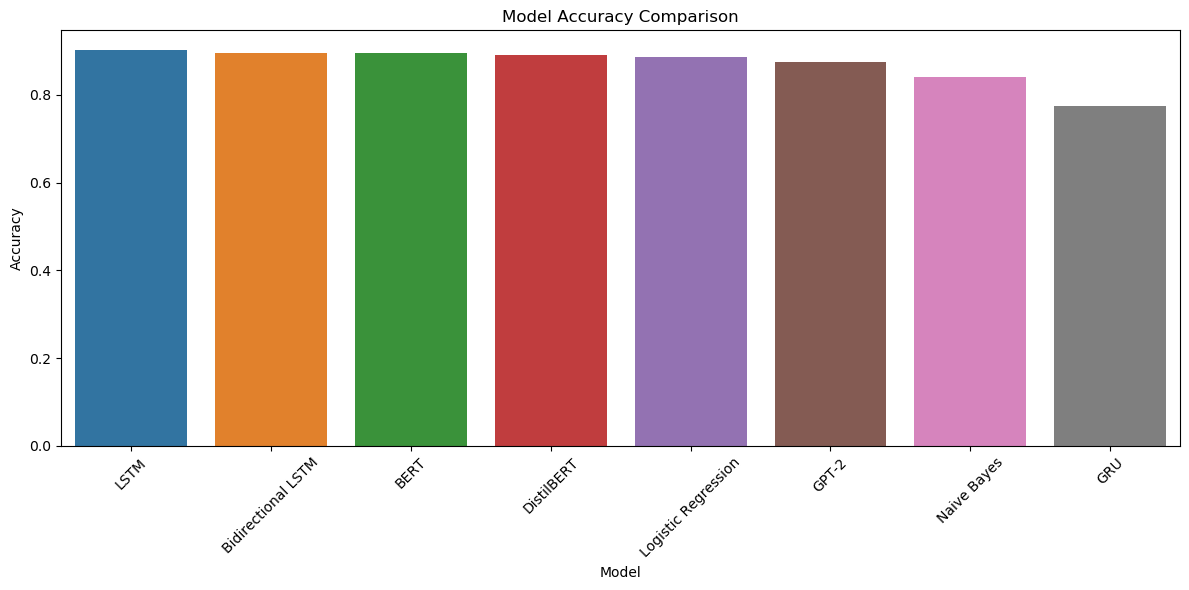

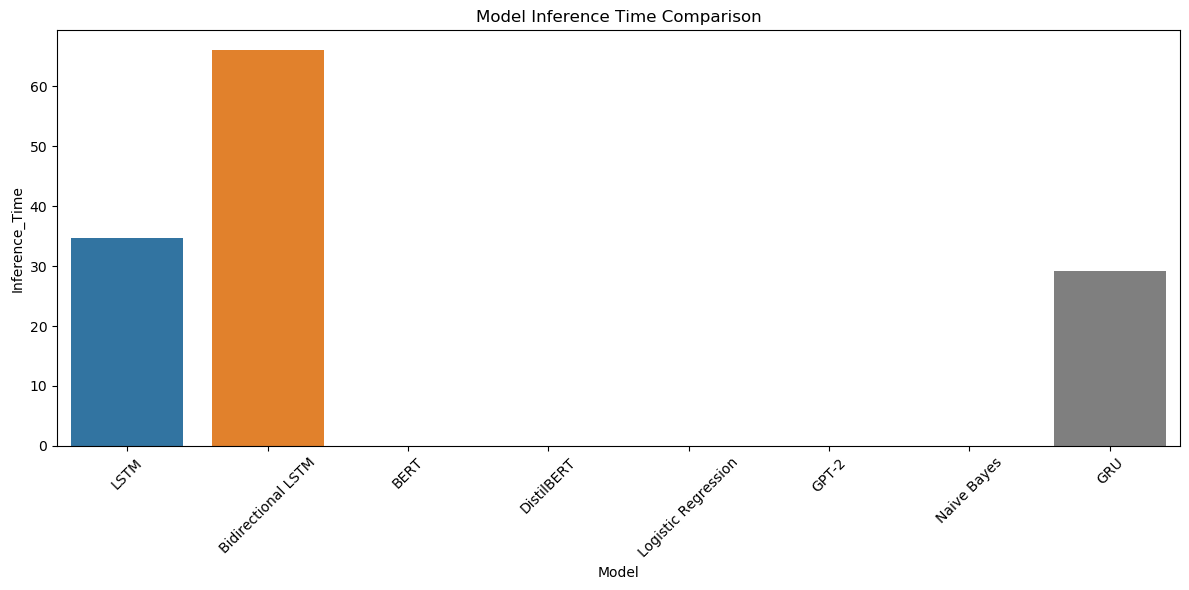

                 Model  Accuracy  Inference_Time
2                 LSTM  0.901575       34.703438
3   Bidirectional LSTM  0.896062       66.068931
5                 BERT  0.894375        0.000000
6           DistilBERT  0.890825        0.000000
0  Logistic Regression  0.886000        0.003608
7                GPT-2  0.874425        0.000000
1          Naive Bayes  0.840225        0.011798
4                  GRU  0.774638       29.156972


In [47]:
# Get transformer results
transformer_results = [bert_results, distilbert_results, gpt_results]

# Run comparison
comparison_df = compare_all_models(classical_results, dl_results, transformer_results)
print(comparison_df)

In [48]:
# Function to apply trained models to unlabeled Amazon review data
def label_amazon_reviews(model, vectorizer, unlabeled_data, model_type='classical'):
    """
    Apply trained sentiment model to unlabeled Amazon reviews

    Parameters:
    - model: Trained sentiment analysis model
    - vectorizer: Text vectorizer (for classical models)
    - unlabeled_data: DataFrame containing unlabeled Amazon reviews
    - model_type: Type of model ('classical', 'deep_learning', or 'transformer')

    Returns:
    - DataFrame with predicted sentiment labels
    """
    reviews = unlabeled_data['Review'].apply(preprocess_text)

    if model_type == 'classical':
        # For classical ML models
        X_features = vectorizer.transform(reviews)
        predictions = model.predict(X_features)

    elif model_type == 'deep_learning':
        # For deep learning models
        X_seq = tokenizer.texts_to_sequences(reviews)
        X_pad = pad_sequences(X_seq, maxlen=max_len)
        predictions = (model.predict(X_pad) > 0.5).astype("int32").flatten()

    elif model_type == 'transformer':
        # For transformer models
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        model.to(device)
        model.eval()

        predictions = []
        batch_size = 16

        # Process in batches to avoid memory issues
        for i in range(0, len(reviews), batch_size):
            batch_texts = reviews.iloc[i:i+batch_size]

            encoded_dict = tokenizer.batch_encode_plus(
                batch_texts.tolist(),
                add_special_tokens=True,
                max_length=128,
                padding='max_length',
                return_attention_mask=True,
                return_tensors='pt',
                truncation=True
            )

            batch_inputs = encoded_dict['input_ids'].to(device)
            batch_masks = encoded_dict['attention_mask'].to(device)

            with torch.no_grad():
                outputs = model(batch_inputs, attention_mask=batch_masks)

            logits = outputs.logits
            batch_predictions = torch.argmax(logits, dim=1).cpu().numpy()
            predictions.extend(batch_predictions)

    # Add predictions to DataFrame
    labeled_data = unlabeled_data.copy()
    labeled_data['Label'] = predictions

    return labeled_data

In [ ]:
"""
# Example: How to apply the best model to new unlabeled data
# Assuming we have new unlabeled Amazon reviews in a CSV file

# Load unlabeled data
unlabeled_data = pd.read_csv('unlabeled_amazon_reviews.csv')

# Apply the best model (based on comparison results)
# For example, using BERT if it's the best
labeled_data = label_amazon_reviews(
    model=bert_model,
    vectorizer=None,  # Not needed for transformers
    unlabeled_data=unlabeled_data,
    model_type='transformer'
)

# Save the labeled data
labeled_data.to_csv('labeled_amazon_reviews.csv', index=False)
"""